In [60]:
from feature_extraction_pipeline.open_data_marine_weather.core import MarineWeatherExtractor
from feature_extraction_pipeline.open_data_raw_material_price.core import RawMaterialPriceExtractor
from feature_extraction_pipeline.open_data_terrestrial_weather.core import TerrestrialWeatherExtractor
import pandas as pd
import numpy as np

date="201908"

price, p_key = RawMaterialPriceExtractor(date=date).process()
t_weather, t_key = TerrestrialWeatherExtractor(date=date).process()
m_weather, m_key = MarineWeatherExtractor(date=date).process()

# combine data
weather = pd.merge(
    t_weather.groupby(["일시"]).mean(),
    m_weather.groupby(["일시"]).mean(),
    how='inner', left_on=t_key, right_on=m_key
).reset_index()

dataset = pd.merge(
    price, weather,
    how="left", left_on=p_key, right_on=t_key
).drop("일시", axis=1).astype(dtype={"조사일자": "datetime64"})

# print(dataset)
# print(dataset.to_numpy())

# print(dataset["조사일자"].drop_duplicates().tolist())

2020-03-30 00:24:34:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 00:24:34:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 00:24:34:manager:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201908.csv in s3 'production-bobsim'


In [61]:
time_series = dataset["조사일자"].drop_duplicates()
reverse_series = time_series.sort_values(ascending=False)
reverse_series

38597   2019-08-30
36710   2019-08-29
34797   2019-08-28
32878   2019-08-27
30949   2019-08-26
29022   2019-08-23
27089   2019-08-22
25160   2019-08-21
23235   2019-08-20
21337   2019-08-19
19437   2019-08-16
17518   2019-08-14
15598   2019-08-13
13682   2019-08-12
11734   2019-08-09
9797    2019-08-08
7835    2019-08-07
5874    2019-08-06
3914    2019-08-05
1948    2019-08-02
0       2019-08-01
Name: 조사일자, dtype: datetime64[ns]

In [62]:
import collections

Dataset = collections.namedtuple("Dataset", ["train", "test"])

## adjust train volume fixing test last one day

36710   2019-08-29
36711   2019-08-29
36712   2019-08-29
36713   2019-08-29
36714   2019-08-29
           ...    
38592   2019-08-29
38593   2019-08-29
38594   2019-08-29
38595   2019-08-29
38596   2019-08-29
Name: 조사일자, Length: 1887, dtype: datetime64[ns] 38597   2019-08-30
38598   2019-08-30
38599   2019-08-30
38600   2019-08-30
38601   2019-08-30
           ...    
40507   2019-08-30
40508   2019-08-30
40509   2019-08-30
40510   2019-08-30
40511   2019-08-30
Name: 조사일자, Length: 1915, dtype: datetime64[ns]
34797   2019-08-28
34798   2019-08-28
34799   2019-08-28
34800   2019-08-28
34801   2019-08-28
           ...    
38592   2019-08-29
38593   2019-08-29
38594   2019-08-29
38595   2019-08-29
38596   2019-08-29
Name: 조사일자, Length: 3800, dtype: datetime64[ns] 38597   2019-08-30
38598   2019-08-30
38599   2019-08-30
38600   2019-08-30
38601   2019-08-30
           ...    
40507   2019-08-30
40508   2019-08-30
40509   2019-08-30
40510   2019-08-30
40511   2019-08-30
Name: 조사일자, Length: 

5874    2019-08-06
5875    2019-08-06
5876    2019-08-06
5877    2019-08-06
5878    2019-08-06
           ...    
38592   2019-08-29
38593   2019-08-29
38594   2019-08-29
38595   2019-08-29
38596   2019-08-29
Name: 조사일자, Length: 32723, dtype: datetime64[ns] 38597   2019-08-30
38598   2019-08-30
38599   2019-08-30
38600   2019-08-30
38601   2019-08-30
           ...    
40507   2019-08-30
40508   2019-08-30
40509   2019-08-30
40510   2019-08-30
40511   2019-08-30
Name: 조사일자, Length: 1915, dtype: datetime64[ns]
3914    2019-08-05
3915    2019-08-05
3916    2019-08-05
3917    2019-08-05
3918    2019-08-05
           ...    
38592   2019-08-29
38593   2019-08-29
38594   2019-08-29
38595   2019-08-29
38596   2019-08-29
Name: 조사일자, Length: 34683, dtype: datetime64[ns] 38597   2019-08-30
38598   2019-08-30
38599   2019-08-30
38600   2019-08-30
38601   2019-08-30
           ...    
40507   2019-08-30
40508   2019-08-30
40509   2019-08-30
40510   2019-08-30
40511   2019-08-30
Name: 조사일자, Length

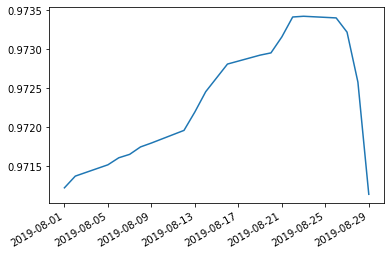

In [65]:
from model.linear_regression import LinearRegressionModel
import matplotlib.pyplot as plt
import functools


reverse_list = reverse_series.tolist()
final_day = reverse_list[0]

def plot(s: pd.Series):
    plt.hist(s, density=True)
    plt.show()


def split_xy(df: pd.DataFrame):
    return df.drop(columns=["당일조사가격", "조사일자"]), df["당일조사가격"]
    

def get_score(train, test):
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    regr = LinearRegressionModel(x_train, y_train)
    regr.fit()
    return regr.score()

def adjust_train_volume(x, df):
    train = df[(x <= df.조사일자.dt.date) & (df.조사일자.dt.date < final_day)]
    test = df[df.조사일자.dt.date == final_day]
    print(train.조사일자, test.조사일자)
    return get_score(train, test)

score_list = list(map(functools.partial(adjust_train_volume, df=dataset), reverse_list[1:]))
pd.Series(score_list, index=reverse_list[1:]).plot()


In [64]:
from model.linear_regression import LinearRegressionModel


X, y = split_xy(dataset)
print(X.count())

regr = LinearRegressionModel(X[:-2000], y[:-2000])
regr.fit()
print(regr.score())
predictions = regr.predict(X[-2000:])
print(predictions, y[-2000:])

품목명_갈치류갈치은갈치냉동           40512
품목명_갈치류갈치은갈치생선           40512
품목명_감자감자수미수미             40512
품목명_건가공(포)류건오징어오징어포일반    40512
품목명_건가공(해조)류건미역자연미역일반    40512
                         ...  
평균 유의 파고(m)              40512
최고 유의 파고(m)              40512
최고 최대 파고(m)              40512
최고 파주기(sec)              40512
평균 파주기(sec)              40512
Length: 150, dtype: int64
0.9712425198835113
[ 7.35076904e+00  6.24353027e+00  7.75061035e+00 ... -4.12865237e+08
 -4.12865237e+08 -4.12865236e+08] 38512    6.898715
38513    6.212606
38514    7.919720
38515    6.526495
38516    7.467942
           ...   
40507    7.356918
40508    7.062192
40509    6.572283
40510    6.965080
40511    7.609697
Name: 당일조사가격, Length: 2000, dtype: float64
